# Using the Nabu library from Python

This notebook shows how to use the Nabu software for performing a basic reconstruction of a tomography dataset.  
The computations are done on a local machine with a GPU and Cuda available.

## 1 - Load the dataset informations

We must provide `nabu` with the the configuration file (`nabu.conf`), describing the path to the dataset and the processing steps. This is the equivalent of the `.par` file in PyHST2. In this file, no information is given on the detector size, energy, distance, etc: these informations are extracted from the dataset metadata.


In [1]:
from nabu.resources.processconfig import ProcessConfig

In [2]:
conf = ProcessConfig("/scratch/paleo/bamboo/nabu.conf")

Loading darks and refs from /scratch/paleo/bamboo/[XXX]_tomwer_processes.h5
Removing unused radios


In [3]:
# We can easily get information on the processing steps.
nabu_config = conf.nabu_config
print(nabu_config)
# The same can be done with the dataset structure
dataset_infos = conf.dataset_infos
# print([getattr(dataset_infos, attr) for attr in ["energy", "distance", "n_angles", "radio_dims"]])

{'dataset': {'location': '/scratch/paleo/bamboo/bamboo_nxtomomill.h5', 'binning': 1, 'binning_z': 1, 'projections_subsampling': 1}, 'preproc': {'flatfield_enabled': True, 'ccd_filter_enabled': False, 'ccd_filter_threshold': 0.04, 'double_flatfield_enabled': True, 'dff_sigma': None, 'take_logarithm': True, 'log_min_clip': 1e-06, 'log_max_clip': 10.0}, 'phase': {'method': 'paganin', 'delta_beta': 1.0, 'marge': 50, 'unsharp_coeff': 0.0, 'unsharp_sigma': 0.0, 'padding_type': 'edge'}, 'reconstruction': {'method': 'FBP', 'angles_file': None, 'rotation_axis_position': 1358.0, 'axis_correction_file': None, 'angle_offset': 0.0, 'fbp_filter_type': 'ramlak', 'padding_type': 'edge', 'enable_halftomo': False, 'start_x': 0, 'end_x': 2559, 'start_y': 0, 'end_y': 2559, 'start_z': 1000, 'end_z': 1240, 'iterations': 200, 'optim_algorithm': 'chambolle-pock', 'weight_tv': 0.01, 'preconditioning_filter': True, 'positivity_constraint': True}, 'output': {'location': '/scratch/paleo/bamboo/', 'file_prefix': '

## 2 - Chunk processing

Nabu processes data by chunks of radios (see the [documentation](http://www.silx.org/pub/nabu/doc/definitions.html#radios-and-sinograms) for more explanations).  
In a first step, we define how to read chunks of radios.

In [4]:
from nabu.io.reader import ChunkReader

What is the largest chunk size we can process ?  
The answer is given by inspecting the current GPU memory, and the processing steps.

In [5]:
from nabu.cuda.utils import get_gpu_memory
from nabu.resources.computations import estimate_chunk_size

In [6]:
chunk_size = estimate_chunk_size(
    get_gpu_memory(0), 
     conf
)
print("Chunk_size = %d" % chunk_size)

Chunk_size = 150


In [7]:
# Load the first 'chunk_size' lines of all the radios
sub_region = (None, None, 0, chunk_size) # start_x, end_x, start_z, end_z
chunk_reader = ChunkReader(dataset_infos.projections, sub_region=sub_region, convert_float=True)

In [8]:
# Load the current chunk
chunk_reader.load_files() # takes some time

In [9]:
print(chunk_reader.files_data.shape)
print(chunk_reader.files_data.dtype)

(4000, 150, 2560)
float32


## 3 - Initialize the GPU

Most of the processing can be done on GPU (or many-core CPU if using OpenCL).  
With `pycuda.gpuarray` (or its OpenCL counterpart `pyopencl.array`), we manipulate array objects with memory residing on device. This allows to avoid extraneous host <-> device copies.

In [10]:
import pycuda.gpuarray as garray
from nabu.cuda.utils import get_cuda_context
import numpy as np

In [11]:
# Create a Cuda context on device ID 0
# By default, all following GPU processings will be bound on this context
ctx = get_cuda_context(device_id=0)

In [12]:
radios = chunk_reader.files_data
n_angles, n_z, n_x = radios.shape
# transfer the chunk on GPU
d_radios = garray.to_gpu(radios)

## 4 - Pre-processing

Pre-processing utilities are available in the `nabu.preproc` module.  
Utilities available with the cuda backend are implemented in a module with a `_cuda` suffix.

### 4.1 - Flat-field

In [13]:
from nabu.preproc.ccd_cuda import CudaFlatField

In [14]:
radios_indices = sorted(conf.dataset_infos.projections.keys())
# Configure the `FlatField` processor
cuda_flatfield = CudaFlatField(
    d_radios.shape, 
    dataset_infos.flats, 
    dataset_infos.darks, 
    radios_indices=radios_indices,
    sub_region=sub_region,
    convert_float=True,
)

In [15]:
# Perform the normalization on GPU
if nabu_config["preproc"]["flatfield_enabled"]:
    print("Doing flat-field")
    cuda_flatfield.normalize_radios(d_radios)

Doing flat-field


### 4.2 - Phase retrieval

In [16]:
from nabu.preproc.phase_cuda import CudaPaganinPhaseRetrieval

In [17]:
energy = dataset_infos.energy
if energy == 0:
    energy = 19 # keV
# Phase retrieval is done on each radio individually, with the sub-region specified above
if nabu_config["phase"]["method"] != None:
    print("Doing phase retrieval")
    cudapaganin = CudaPaganinPhaseRetrieval(
        (n_z, n_x),
        distance=dataset_infos.distance * 1e2,
        energy=energy,
        delta_beta=nabu_config["phase"]["delta_beta"],
        pixel_size=dataset_infos.pixel_size
    )
    for i in range(n_angles):
        cudapaganin.apply_filter(d_radios[i], output=d_radios[i])

Doing phase retrieval


### 4.3 - Logarithm

In [18]:
from nabu.preproc.ccd_cuda import CudaLog

In [19]:
if nabu_config["preproc"]["take_logarithm"]:
    print("Taking logarithm")
    cuda_log = CudaLog(d_radios.shape, clip_min=0.01)
    cuda_log.take_logarithm(d_radios)

Taking logarithm


## 5 - Reconstruction

We use the filtered backprojection with `nabu.reconstruction.fbp`

In [20]:
from nabu.reconstruction.fbp import Backprojector

In [21]:
rec_options = conf.processing_options["reconstruction"]
B = Backprojector(
    (n_angles, n_x), 
    angles=rec_options["angles"], rot_center=rec_options["rotation_axis_position"],
    extra_options={"padding_mode": "edges"}
)
d_recs = garray.zeros((n_z, n_x, n_x), "f")

In [22]:
print("Reconstructing...", end="")
for i in range(n_z):
    B.fbp(radios[:, i, :], output=d_recs[i])
recs = d_recs.get()
print(" ... OK")

Reconstructing... ... OK


## 6 - Visualize

In [23]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


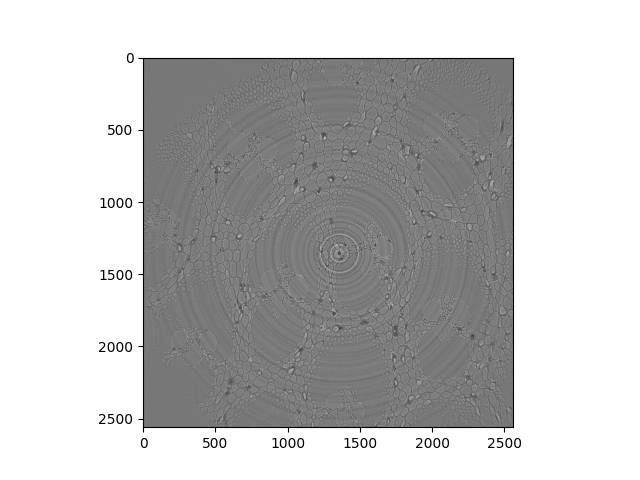

In [24]:
figure()
imshow(recs[0], cmap="gray")